In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


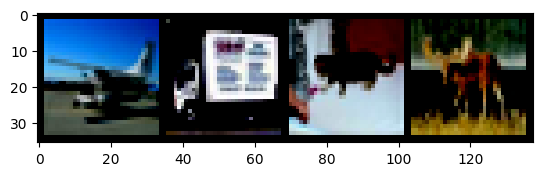

plane truck cat   deer 


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

data_iter = iter(trainloader)
images, labels = next(data_iter)


imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))





In [35]:
import torch.nn as nn
import torch.nn.functional as F
import copy

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,4)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net_SGD = copy.deepcopy(net)
net_Adam = copy.deepcopy(net)

In [36]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimiser1 = optim.SGD(net_SGD.parameters(), lr = 0.001, momentum = 0.9)
optimiser2 = optim.Adam(net_Adam.parameters(), lr = 0.001)

In [48]:
def train_model(net, trainloader, criterion, optimiser, epochs=4):

    for epoch in range(epochs):
    
        running_loss = 0.0
    
        for i, data in enumerate(trainloader,0):
            inputs, labels = data
    
            optimiser.zero_grad()
    
            outputs = net(inputs)
            loss= criterion(outputs,labels)
            loss.backward()
            optimiser.step()
    
            running_loss += loss.item()
            if i%2000 == 1999:
                print(f'[{epoch +1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                
    print('Finished training')

In [38]:
train_model(net_SGD, trainloader, criterion, optimiser1, epochs=3)
train_model(net_Adam, trainloader, criterion, optimiser2, epochs=3)

[1,  2000] loss: 2.192
[1,  4000] loss: 1.860
[1,  6000] loss: 1.663
[1,  8000] loss: 1.564
[1, 10000] loss: 1.520
[1, 12000] loss: 1.464
[2,  2000] loss: 1.374
[2,  4000] loss: 1.373
[2,  6000] loss: 1.368
[2,  8000] loss: 1.312
[2, 10000] loss: 1.316
[2, 12000] loss: 1.296
[3,  2000] loss: 1.221
[3,  4000] loss: 1.227
[3,  6000] loss: 1.198
[3,  8000] loss: 1.207
[3, 10000] loss: 1.188
[3, 12000] loss: 1.176
[4,  2000] loss: 1.095
[4,  4000] loss: 1.122
[4,  6000] loss: 1.124
[4,  8000] loss: 1.124
[4, 10000] loss: 1.106
[4, 12000] loss: 1.109
Finished training
[1,  2000] loss: 1.889
[1,  4000] loss: 1.604
[1,  6000] loss: 1.530
[1,  8000] loss: 1.470
[1, 10000] loss: 1.431
[1, 12000] loss: 1.397
[2,  2000] loss: 1.325
[2,  4000] loss: 1.301
[2,  6000] loss: 1.297
[2,  8000] loss: 1.300
[2, 10000] loss: 1.272
[2, 12000] loss: 1.246
[3,  2000] loss: 1.173
[3,  4000] loss: 1.190
[3,  6000] loss: 1.195
[3,  8000] loss: 1.189
[3, 10000] loss: 1.177
[3, 12000] loss: 1.170
[4,  2000] loss:

In [39]:
def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

# After training
print("SGD model performance:")
evaluate(net_SGD, testloader)

print("Adam model performance:")
evaluate(net_Adam, testloader)





SGD model performance:
Accuracy: 63.74%
Adam model performance:
Accuracy: 63.51%


In [46]:
def class_wise_accuracy(model, testloader, model_name):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    accuracies = []
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracies.append(accuracy)
        print(f'Accuracy for class: {classname:5s} in model {model_name} is {accuracy:.1f} %')

    # Plot histogram
    plt.figure(figsize=(10,6))
    plt.bar(classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Class-wise Accuracy for model {model_name}')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

Accuracy for class: plane in model SGD is 70.6 %
Accuracy for class: car   in model SGD is 78.3 %
Accuracy for class: bird  in model SGD is 57.6 %
Accuracy for class: cat   in model SGD is 40.7 %
Accuracy for class: deer  in model SGD is 65.1 %
Accuracy for class: dog   in model SGD is 36.0 %
Accuracy for class: frog  in model SGD is 72.1 %
Accuracy for class: horse in model SGD is 69.1 %
Accuracy for class: ship  in model SGD is 80.4 %
Accuracy for class: truck in model SGD is 67.4 %


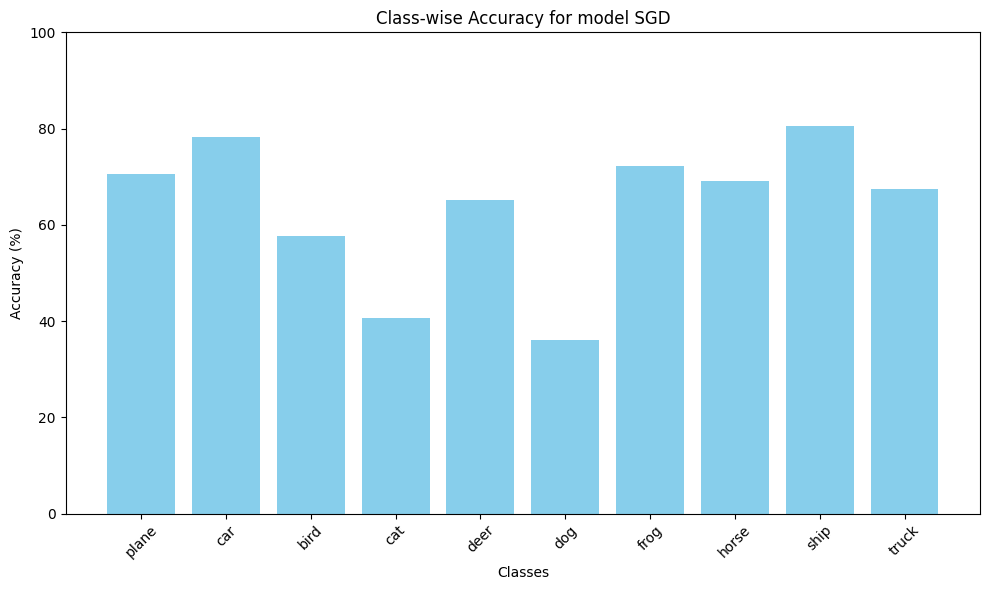

Accuracy for class: plane in model Adam is 68.3 %
Accuracy for class: car   in model Adam is 71.9 %
Accuracy for class: bird  in model Adam is 45.3 %
Accuracy for class: cat   in model Adam is 56.6 %
Accuracy for class: deer  in model Adam is 56.9 %
Accuracy for class: dog   in model Adam is 52.7 %
Accuracy for class: frog  in model Adam is 73.2 %
Accuracy for class: horse in model Adam is 62.9 %
Accuracy for class: ship  in model Adam is 81.8 %
Accuracy for class: truck in model Adam is 65.6 %


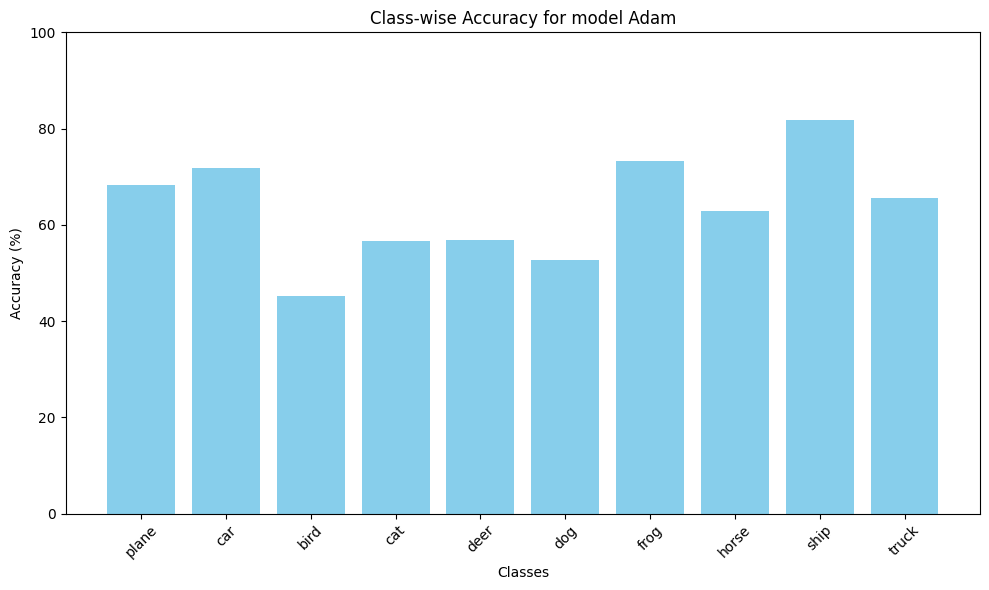

In [47]:
class_wise_accuracy(net_SGD, testloader, "SGD")
class_wise_accuracy(net_Adam, testloader, "Adam")